<a href="https://colab.research.google.com/github/NalchajyanHayk/Training-VGG-like-and-ResNet-like-Networks/blob/main/Project_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hayk Nalchajyan
## Training VGG-like and ResNet-like Networks


Let's train network to classify images from Tiny ImageNet!

The task contains three parts:

1. Make yourself familiar with ordinary training script structure and train good old vgg-like network
2. Improve quality with resnet-like network
3. Improve quality with test-time augmentation

But first of all let's take a look on data

# Tiny ImageNet dataset
In this homework we shall focus on the image recognition problem on Tiny Image Net dataset. This dataset contains
* 100k images of shape 3x64x64
* 200 different classes: snakes, spiders, cats, trucks, grasshopper, gull, etc.

In fact, it is a subset of ImageNet dataset with 4x downscaled images.

## Image examples



<tr>
    <td> <img src="https://github.com/yandexdataschool/Practical_DL/blob/sem3spring2019/week03_convnets/tinyim3.png?raw=1" alt="Drawing" style="width:90%"/> </td>
    <td> <img src="https://github.com/yandexdataschool/Practical_DL/blob/sem3spring2019/week03_convnets/tinyim2.png?raw=1" alt="Drawing" style="width:90%"/> </td>
</tr>


<tr>
    <td> <img src="https://github.com/yandexdataschool/Practical_DL/blob/sem3spring2019/week03_convnets/tiniim.png?raw=1" alt="Drawing" style="width:90%"/> </td>
</tr>

## Step 0 - data loading

In [ ]:
#!S:bash
# if you are in colab, just add '!' in the start of the following line
!wget --no-check-certificate 'https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall21/homework01/tiny_img.py' -O tiny_img.py
!wget --no-check-certificate 'https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall21/homework01/tiny_img_dataset.py' -O tiny_img_dataset.py

--2024-03-25 11:27:03--  https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall21/homework01/tiny_img.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 813 [text/plain]
Saving to: 'tiny_img.py'

tiny_img.py         100%[===================>]     813  --.-KB/s    in 0s      

2024-03-25 11:27:03 (22.8 MB/s) - 'tiny_img.py' saved [813/813]

--2024-03-25 11:27:04--  https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall21/homework01/tiny_img_dataset.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response

In [ ]:
#!L
from tiny_img import download_tinyImg200
data_path = '.'
download_tinyImg200(data_path)

Dataset was downloaded to './tiny-imagenet-200.zip'
Extract downloaded dataset to '.'


## Task 1. Training script structure and vgg-like network

In order to train a neural network for a specific task you should write code for 4 task-specific blocks and for one task-independed block:
1. data loader (data provider) - how to load and augment data for nn training
2. neural network architecture - what will be trained
3. loss function (+ auxilary metrics on train and validation set) - how to check neural network quality
4. optimizer and training schedule - how neural network will be trained
5. "Train loop" - what exactly to do for each batch, how often to check validation error, how often to save network and so on. This code could be written in general way and reused between different training scripts


In [ ]:
#!L
import torch
import torchvision
from torchvision import transforms
import tqdm

def get_computing_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    return device

device = get_computing_device()
print(f"Our main computing device is '{device}'")

Our main computing device is 'cuda:0'


### 1.1 Data loader and data augmentation
Normally there are two connected abstractions for data manipulation:
- Dataset (`torch.utils.data.Dataset` and its subclasses from `torchvision.datasets`) - some black-box that keeps and preprocesses separate elements of dataset. In particular, single sample augmentations live on this level usually.
- DataLoader (`torch.utils.data.DataLoader`) - structure that combines separate elements in batch.

Let's deal with training dataset. Here are some simple augmentations that we are going to use in our experiments:

In [ ]:
train_trainsforms = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.RandomRotation(5),

     transforms.ColorJitter()
    ]
)

For training dataset we will use custom dataset that will keep all training data in RAM. If your amount of RAM memory is low, you can use `torchvision.datasets.ImageFolder()` instead.

In [ ]:
#!L
import tiny_img_dataset
# you may use torchvision.datasets.ImageFolder() with the same parameters for loading train dataset
train_dataset = tiny_img_dataset.TinyImagenetRAM('tiny-imagenet-200/train', transform=train_trainsforms)

tiny-imagenet-200/train: 100%|██████████| 200/200 [01:34<00:00,  2.11it/s]


Now validation. Take a look at `tiny-imagenet-200/val` folder and compare it with `tiny-imagenet-200/train`. Looks different, right? So we can't use `TinyImagenetRAM` for loading the validation set. Let's write a custom dataset instead but with the same behavior like `TinyImagenetRAM`.

In [ ]:
from torch.utils.data import Dataset
import os
from PIL import Image
import tqdm

class TinyImagenetValDataset(Dataset):
    def __init__(self, root, transform=transforms.ToTensor()):
        super().__init__()

        self.root = root
        with open(os.path.join(root, 'val_annotations.txt')) as f:
            annotations = []
            for line in f:
                img_name, class_label = line.split('\t')[:2]
                annotations.append((img_name, class_label))

        self.classes = sorted(set([x[1] for x in annotations]))

        assert len(self.classes) == 200, len(self.classes)
        assert all(self.classes[i] < self.classes[i+1] for i in range(len(self.classes)-1)), 'classes should be ordered'

        self.class_to_idx = {item: index for index, item in enumerate(self.classes)}

        self.transform = transform

        self.images, self.targets = [], []
        for img_name, class_name in tqdm.tqdm(annotations, desc=root):
            img_path = os.path.join(root, 'images', img_name)
            image = tiny_img_dataset.read_rgb_image(img_path)

            assert image.shape == (64, 64, 3), image.shape
            self.images.append(Image.fromarray(image))
            self.targets.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]
        image = self.transform(image)
        target = self.targets[index]

        return image, target


Let's finally load validation dataset. Normally you don't need to augment validation data.

In [ ]:
val_dataset = TinyImagenetValDataset('tiny-imagenet-200/val', transform=transforms.ToTensor())

assert all(train_dataset.classes[i] == val_dataset.classes[i] for i in range(200)), \
    'class order in train and val datasets should be the same'
assert all(train_dataset.class_to_idx[elem] == val_dataset.class_to_idx[elem] for elem in train_dataset.classes), \
    'class indices should be the same'

tiny-imagenet-200/val: 100%|██████████| 10000/10000 [00:02<00:00, 4662.97it/s]


For the most cases the default `DataLoader` will be good enough.

In [ ]:
#!L
batch_size = 64
train_batch_gen = torch.utils.data.DataLoader(train_dataset,
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=12)

In [ ]:
#!L
val_batch_gen = torch.utils.data.DataLoader(val_dataset,
                                            batch_size=batch_size,
                                            shuffle=False,
                                            num_workers=12)

### 1.2 Neural network definition

"VGG-like network" usually means that the network is a sequence of convolutions with MaxPooling for downsampling. Here is a table from the original paper ["Very Deep Convolutional Networks for Large-Scale Image Recognition"](https://arxiv.org/abs/1409.1556) that describes classical configurations of VGG networks (often referred as VGG-A, VGG-B and so on using column name as an identificator or as VGG16, VGG19 and so on using amount of layers as an identificator)
![image.png](https://pytorch.org/assets/images/vgg.png)

These network configurations were designed for ImageNet dataset. Since images in tiny-imagenet are 4x downsampled, we are going to design our own configuration by reducing: 1) amount of layers; 2) amount of neurons in layers; 3) amount of maxpooling layers which downsample feature maps

Our network config will be [Conv(16), Conv(16), MaxPool] + [Conv(32), Conv(32), MaxPool] + [Conv(64), Conv(64), MaxPool] + [Conv(128), Conv(128)] + [GlobalAveragePooling] + [FC(200) + softmax]

We use Conv(128) and GlobalAveragePooling instead of image flattening and FC layers for reducing the amount of parameters.

In [ ]:
#!L
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

And one more thing. VGG was designed before BatchNormalization was introduced. Nowadays it will be stupid if we don't use batch normalization in our network. So let's define simple module containing convolution, batch norm and relu in it and build our network using this module. Here is also implementation of GlobalAveragePooling given for you as example of custom module.

In [ ]:
# #!L
import torch
import torch.nn as nn

class GlobalAveragePool(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, x):
        return torch.mean(x, dim=self.dim)

class ConvBNRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding='same'):
        super().__init__()

        padding = padding if padding != 'same' else kernel_size // 2
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

def create_vgg_like_network(config=None):
    """
    Creates VGG like network according to config
    """
    model = nn.Sequential()

    default_config = [[16,16], [32, 32], [64, 64], [128, 128]]
    config = config or default_config

    in_channels = 3
    for block_index in range(len(config)):
        for layer_index_in_block in range(len(config[block_index])):
            out_channels = config[block_index][layer_index_in_block]

            model.add_module(f'conv{block_index}_{layer_index_in_block}',
                             ConvBNRelu(in_channels, out_channels, kernel_size=3, padding='same'))

            in_channels = out_channels

        if block_index != len(config) - 1:
            model.add_module(f'mp_{block_index}', nn.MaxPool2d(3, stride=2))

    model.add_module('pool', GlobalAveragePool(dim=(2,3)))
    model.add_module('logits', nn.Linear(out_channels, 200))
    return model




Here are our model created!

In [ ]:
model = create_vgg_like_network()
print(model)
model = model.to(device)

### 1.3 Loss function definition

Usually cross-entropy (negative log-likelihood) is used as loss function for image classification.

In [ ]:
#!L
def compute_loss(predictions, gt):
    return F.cross_entropy(predictions, gt).mean()

### 1.4 Optimizer and training schedule

Let's train our network using Adam with default parameters.

For training by `torch.optim.SGD` you usually have to define training schedule - a way how to decrease learning rate during training. But since in adam all the gradients are scaled on their second momentum, the effect of a good training schedule is not so critical for training as in SGD. So we are going to act like lazy data scientists and will not decrease learning rate at all. But you may play with scheduling using for example `torch.optim.lr_scheduler.ExponentialLR`, see the [documentation](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) with explanation how to use it.

In [ ]:
opt = torch.optim.Adam(model.parameters())

In [ ]:
print(device)

cuda:0


### 1.5 Training loop

Let's combine the previously defined things together.

In [ ]:
import numpy as np
import time


def eval_model(model, data_generator):
    accuracy = []
    model.train(False) # disable dropout / use averages for batch_norm
    with torch.no_grad():
        for X_batch, y_batch in data_generator:
            X_batch = X_batch.to(device)
            logits = model(X_batch)
            y_pred = logits.max(1)[1].data
            accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy()))
    return np.mean(accuracy)


def train_model(model, optimizer, train_data_generator):
    train_loss = []
    model.train(True)
    for (X_batch, y_batch) in tqdm.tqdm(train_data_generator):
        optimizer.zero_grad()

        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        predictions = model(X_batch)

        loss = compute_loss(predictions, y_batch)

        loss.backward()
        optimizer.step()
        train_loss.append(loss.cpu().item())

    return np.mean(train_loss)



def train_loop(model, optimizer, train_data_generator, val_data_generator, num_epochs):
    """
    num_epochs - total amount of full passes over training data
    """
    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss = train_model(model, optimizer, train_data_generator)

        val_accuracy = eval_model(model, val_data_generator)

        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_accuracy * 100))

### 1.6 Training

All the preparation is done, time to run the training!

Normally after training for 30 epochs you should get a neural network that predicts labels with >40% accuracy here.

In [ ]:
train_loop(model, opt, train_batch_gen, val_batch_gen, num_epochs=15)

100%|██████████| 1563/1563 [00:46<00:00, 33.36it/s]


Epoch 1 of 15 took 48.660s
  training loss (in-iteration): 	4.256220
  validation accuracy: 			15.59 %


100%|██████████| 1563/1563 [00:45<00:00, 34.31it/s]


Epoch 2 of 15 took 47.319s
  training loss (in-iteration): 	3.538938
  validation accuracy: 			18.58 %


100%|██████████| 1563/1563 [00:46<00:00, 33.76it/s]


Epoch 3 of 15 took 48.247s
  training loss (in-iteration): 	3.219099
  validation accuracy: 			25.95 %


100%|██████████| 1563/1563 [00:45<00:00, 34.21it/s]


Epoch 4 of 15 took 47.452s
  training loss (in-iteration): 	3.019080
  validation accuracy: 			28.07 %


100%|██████████| 1563/1563 [00:46<00:00, 33.69it/s]


Epoch 5 of 15 took 48.197s
  training loss (in-iteration): 	2.867175
  validation accuracy: 			28.69 %


100%|██████████| 1563/1563 [00:45<00:00, 34.17it/s]


Epoch 6 of 15 took 47.526s
  training loss (in-iteration): 	2.754802
  validation accuracy: 			30.64 %


100%|██████████| 1563/1563 [00:45<00:00, 34.05it/s]


Epoch 7 of 15 took 47.651s
  training loss (in-iteration): 	2.663927
  validation accuracy: 			33.23 %


100%|██████████| 1563/1563 [00:45<00:00, 34.34it/s]


Epoch 8 of 15 took 47.293s
  training loss (in-iteration): 	2.581252
  validation accuracy: 			35.00 %


100%|██████████| 1563/1563 [00:45<00:00, 34.30it/s]


Epoch 9 of 15 took 47.451s
  training loss (in-iteration): 	2.510470
  validation accuracy: 			35.16 %


100%|██████████| 1563/1563 [00:45<00:00, 34.23it/s]


Epoch 10 of 15 took 47.426s
  training loss (in-iteration): 	2.459580
  validation accuracy: 			36.77 %


100%|██████████| 1563/1563 [00:45<00:00, 34.41it/s]


Epoch 11 of 15 took 47.498s
  training loss (in-iteration): 	2.404364
  validation accuracy: 			37.16 %


100%|██████████| 1563/1563 [00:45<00:00, 34.52it/s]


Epoch 12 of 15 took 47.073s
  training loss (in-iteration): 	2.356629
  validation accuracy: 			37.70 %


100%|██████████| 1563/1563 [00:45<00:00, 34.36it/s]


Epoch 13 of 15 took 47.340s
  training loss (in-iteration): 	2.313680
  validation accuracy: 			37.96 %


100%|██████████| 1563/1563 [00:45<00:00, 34.04it/s]


Epoch 14 of 15 took 47.702s
  training loss (in-iteration): 	2.280843
  validation accuracy: 			39.91 %


100%|██████████| 1563/1563 [00:45<00:00, 34.31it/s]


Epoch 15 of 15 took 47.339s
  training loss (in-iteration): 	2.239902
  validation accuracy: 			40.01 %


## Task 2. Say Hello to ResNets

In this part you need to redefine your model, all the rest will be the same. As with VGG, we are going to define ResNet-like model, not a classic architecture, designed for ImageNet classification.

"ResNet-like" usually means that your network consists of "residual blocks". There are two types of blocks that widely used: with two convolutions and with three convolutions:
![resnet_blocks](https://miro.medium.com/max/613/1*zS2ChIMwAqC5DQbL5yD9iQ.png)

In practice, blocks with three convolutions are used often since they allows to build more deep network with less parameters. Blocks with two convolutions are usually used for comparisson with non-residual networks, espatially with VGG and AlexNet.

Here is a table from the paper "[Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf)" that describes classical configurations of ResNet networks. Usually they are referred as ResNet-18, ResNet-34 and so on using amount of layers as identificator. Note, that networks starting from ResNet-50 are based on 3-convolutional blocks. In fact ResNet-18 and ResNet-34 were introduces just for comparison with VGG, while ResNet-50 is what usually used in practice as a good baseline.

![img](https://miro.medium.com/max/2400/1*aq0q7gCvuNUqnMHh4cpnIw.png)

As with VGG, we are going to build our own config for network. Let's use 2-convolutional blocks for comparisson with vgg and take network like [Conv7x7 - 32] + [conv32-block, conv32-block] + [conv64-block, conv64-block] + [conv128-block, conv128-block] + [GlobalAveragePooling] + fc200 + softmax

Comparing to ResNet18, we decreased the amount of filters and removed max-pooling in the beggining and the last set of convolutions for keeping meaningful spatial resolution.

In [ ]:

class ResNetBlock2(nn.Module):
    """
    Module implements the following function:

    output = relu(F(input) + Residual(input)), where:
        Residual(x) = Conv + bn + relu + conv + bn
        F(x) = x                                        , if in_channels == out_channels and stride == 1
             = Conv1x1(in_channel, out_channel, stride) , otherwise
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding='same'):
        super().__init__()

        padding = padding if padding != 'same' else kernel_size // 2

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, 1, padding)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.relu2 = nn.ReLU()

        self.conv3 = None
        if in_channels != out_channels or stride != 1:
            self.conv3 = nn.Conv2d(in_channels, out_channels, 1, stride, padding=0)

    def forward(self, x):

        residual = x

        residual = self.conv1(residual)
        residual = self.bn1(residual)
        residual = self.relu1(residual)

        residual = self.conv2(residual)
        residual = self.bn2(residual)

        if self.conv3 is not None:
            x = self.conv3(x)

        result = self.relu2(residual + x)
        return result

def create_resnet_like_network():
    model = nn.Sequential()

    config = [[32, 32], [64, 64], [128, 128]]
    model.add_module('init_conv', ConvBNRelu(3, 32, kernel_size=7, stride=2, padding=3))

    in_channels = 32
    for i in range(len(config)):
        for j in range(len(config[i])):

            out_channels = config[i][j]
            stride = 2 if i != 0 and j == 0 else 1
            model.add_module(f'res_block_{i}_{j}',
                             ResNetBlock2(in_channels, out_channels, kernel_size=3, stride=stride, padding='same'))

            in_channels = out_channels

    model.add_module('pool', GlobalAveragePool((2,3)))
    model.add_module('logits', nn.Linear(out_channels, 200))
    return model


In [ ]:
model = create_resnet_like_network()
model.to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001)
train_loop(model, opt, train_batch_gen, val_batch_gen, num_epochs=15)

100%|██████████| 1563/1563 [00:47<00:00, 32.58it/s]


Epoch 1 of 15 took 49.874s
  training loss (in-iteration): 	4.507648
  validation accuracy: 			12.31 %


100%|██████████| 1563/1563 [00:48<00:00, 32.21it/s]


Epoch 2 of 15 took 50.390s
  training loss (in-iteration): 	3.734231
  validation accuracy: 			18.09 %


100%|██████████| 1563/1563 [00:48<00:00, 32.17it/s]


Epoch 3 of 15 took 50.458s
  training loss (in-iteration): 	3.346913
  validation accuracy: 			26.14 %


100%|██████████| 1563/1563 [00:48<00:00, 32.51it/s]


Epoch 4 of 15 took 49.974s
  training loss (in-iteration): 	3.078455
  validation accuracy: 			30.54 %


100%|██████████| 1563/1563 [00:48<00:00, 32.18it/s]


Epoch 5 of 15 took 50.474s
  training loss (in-iteration): 	2.872133
  validation accuracy: 			32.25 %


100%|██████████| 1563/1563 [00:48<00:00, 32.49it/s]


Epoch 6 of 15 took 49.969s
  training loss (in-iteration): 	2.713731
  validation accuracy: 			34.77 %


100%|██████████| 1563/1563 [00:48<00:00, 32.15it/s]


Epoch 7 of 15 took 50.480s
  training loss (in-iteration): 	2.578406
  validation accuracy: 			31.83 %


100%|██████████| 1563/1563 [00:48<00:00, 32.49it/s]


Epoch 8 of 15 took 49.964s
  training loss (in-iteration): 	2.470247
  validation accuracy: 			38.01 %


100%|██████████| 1563/1563 [00:48<00:00, 32.09it/s]


Epoch 9 of 15 took 50.584s
  training loss (in-iteration): 	2.371134
  validation accuracy: 			39.38 %


100%|██████████| 1563/1563 [00:48<00:00, 32.00it/s]


Epoch 10 of 15 took 50.720s
  training loss (in-iteration): 	2.290271
  validation accuracy: 			40.73 %


100%|██████████| 1563/1563 [00:48<00:00, 32.37it/s]


Epoch 11 of 15 took 50.184s
  training loss (in-iteration): 	2.214344
  validation accuracy: 			41.06 %


100%|██████████| 1563/1563 [00:48<00:00, 32.34it/s]


Epoch 12 of 15 took 50.244s
  training loss (in-iteration): 	2.142911
  validation accuracy: 			41.92 %


100%|██████████| 1563/1563 [00:48<00:00, 32.34it/s]


Epoch 13 of 15 took 50.190s
  training loss (in-iteration): 	2.086600
  validation accuracy: 			42.94 %


100%|██████████| 1563/1563 [00:48<00:00, 32.17it/s]


Epoch 14 of 15 took 50.444s
  training loss (in-iteration): 	2.030091
  validation accuracy: 			43.01 %


100%|██████████| 1563/1563 [00:48<00:00, 32.47it/s]


Epoch 15 of 15 took 50.013s
  training loss (in-iteration): 	1.979917
  validation accuracy: 			43.21 %


If you were attentive to our resnet network, you may notice that it has almost 2x more parameters and 2x deeper than vgg-like network. Let's define comparable vgg-like network by doubling amount of conv layers.

Our new vgg-like architecture will be [Conv(16), Conv(16), MaxPool] + [Conv(32), Conv(32), Conv(32), Conv(32), MaxPool] + [Conv(64), Conv(64), Conv(64), Conv(64), MaxPool] + [Conv(128), Conv(128), Conv(128), Conv(128)] + [GlobalAveragePooling] + [FC(200) + softmax]

In [ ]:
model = create_vgg_like_network(config=[[16,16], [32,32,32,32], [64, 64, 64, 64], [128, 128, 128, 128]])
model = model.to(device)
opt = torch.optim.Adam(model.parameters())
train_loop(model, opt, train_batch_gen, val_batch_gen, num_epochs=15)

100%|██████████| 1563/1563 [00:50<00:00, 31.22it/s]


Epoch 1 of 15 took 52.087s
  training loss (in-iteration): 	4.593306
  validation accuracy: 			7.51 %


100%|██████████| 1563/1563 [00:49<00:00, 31.30it/s]


Epoch 2 of 15 took 52.001s
  training loss (in-iteration): 	4.009466
  validation accuracy: 			13.87 %


100%|██████████| 1563/1563 [00:49<00:00, 31.75it/s]


Epoch 3 of 15 took 51.265s
  training loss (in-iteration): 	3.687066
  validation accuracy: 			16.85 %


100%|██████████| 1563/1563 [00:49<00:00, 31.41it/s]


Epoch 4 of 15 took 51.838s
  training loss (in-iteration): 	3.451334
  validation accuracy: 			22.38 %


100%|██████████| 1563/1563 [00:49<00:00, 31.38it/s]


Epoch 5 of 15 took 52.051s
  training loss (in-iteration): 	3.279805
  validation accuracy: 			23.70 %


100%|██████████| 1563/1563 [00:49<00:00, 31.48it/s]


Epoch 6 of 15 took 51.684s
  training loss (in-iteration): 	3.134589
  validation accuracy: 			26.89 %


100%|██████████| 1563/1563 [00:50<00:00, 31.23it/s]


Epoch 7 of 15 took 52.109s
  training loss (in-iteration): 	3.005253
  validation accuracy: 			27.63 %


100%|██████████| 1563/1563 [00:49<00:00, 31.59it/s]


Epoch 8 of 15 took 51.541s
  training loss (in-iteration): 	2.895902
  validation accuracy: 			28.12 %


100%|██████████| 1563/1563 [00:50<00:00, 31.24it/s]


Epoch 9 of 15 took 52.082s
  training loss (in-iteration): 	2.796931
  validation accuracy: 			30.93 %


100%|██████████| 1563/1563 [00:50<00:00, 31.10it/s]


Epoch 10 of 15 took 52.304s
  training loss (in-iteration): 	2.704227
  validation accuracy: 			33.38 %


100%|██████████| 1563/1563 [00:49<00:00, 31.35it/s]


Epoch 11 of 15 took 51.894s
  training loss (in-iteration): 	2.630687
  validation accuracy: 			33.41 %


100%|██████████| 1563/1563 [00:50<00:00, 31.08it/s]


Epoch 12 of 15 took 52.366s
  training loss (in-iteration): 	2.552148
  validation accuracy: 			34.54 %


100%|██████████| 1563/1563 [00:49<00:00, 31.34it/s]


Epoch 13 of 15 took 52.113s
  training loss (in-iteration): 	2.488313
  validation accuracy: 			35.48 %


100%|██████████| 1563/1563 [00:50<00:00, 31.25it/s]


Epoch 14 of 15 took 52.111s
  training loss (in-iteration): 	2.427769
  validation accuracy: 			36.81 %


100%|██████████| 1563/1563 [00:50<00:00, 30.91it/s]


Epoch 15 of 15 took 52.630s
  training loss (in-iteration): 	2.372862
  validation accuracy: 			36.66 %


Do you see the profit from residual connections?

The quality of vgg network in this experiment could be even worse than the quality of vgg network in the first experiment. This is due to gradient vanishing problem that makes it hard to train deep neural networks without residual conections.

# Task 3: Gaussian Blur from Scratch

In [ ]:
!pip install Pillow
!pip install requests

Implement a function that will apply Gaussian Blur on given image without using PyTorch. You may want to use `numpy` for the filters.

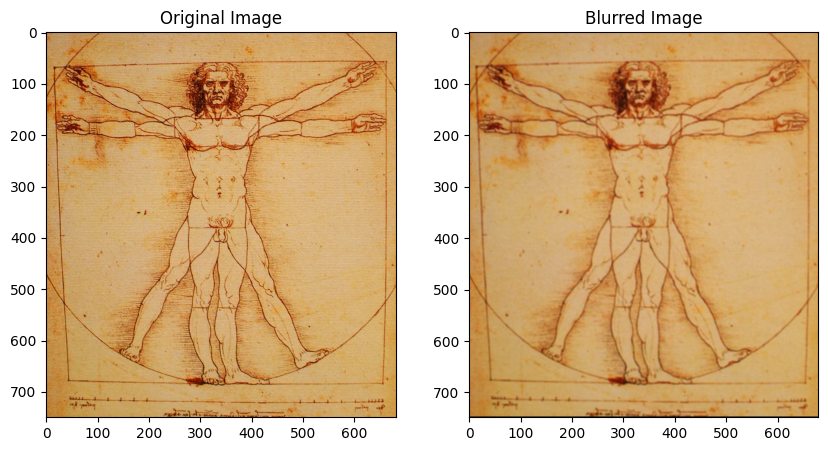

In [ ]:
# YOUR CODE HERE
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import requests


def gaussian_kernel(size, sigma = 1.0):
    size = int(size) // 2
    x,y = np.mgrid[-size:size+1, -size:size+1]
    g = np.exp(-((x**2 + y**2) / (2.0*sigma**2))) / (2.0 * np.pi * sigma**2)
    return g / g.sum()


def padding(image, kernel_size):
    width = kernel_size // 2
    return np.pad(image, [(width, width), (width, width), (0,0)],mode = 'edge')


def gaussian_blur(iamge, kernel_size = 5, sigma = 1.0):
    kernel = gaussian_kernel(kernel_size, sigma)
    padded = padding(image, kernel_size)
    blurred = np.zeros_like(padded)
    #convolution
    for k in range(3):
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                convolved = padded[i:i+kernel_size, j:j+kernel_size, k]
                blurred[i,j,k] = (convolved * kernel).sum()
    blurred = blurred[kernel_size//2:-kernel_size//2, kernel_size//2:-kernel_size//2, :]
    return np.clip(blurred, 0, 255)

def load_image(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert('RGB')
    return np.array(img)

url = 'https://th-thumbnailer.cdn-si-edu.com/pudYlLwHsVzaUG6P4R6IibTiA0g=/1000x750/filters:no_upscale()/https://tf-cmsv2-smithsonianmag-media.s3.amazonaws.com/filer/c6/87/c687edd3-7917-4c25-b112-c032f15ded66/4861890322_136909aa62_b.jpg'
image = load_image(url)
blurred_image = gaussian_blur(image, kernel_size=5, sigma=1.5)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(blurred_image)
plt.title('Blurred Image')
plt.show()

## Task 4 (optional). Test time augmentations

Test-time augmentation (TTA) is a powerful techneque that allows you to trade inference time for quality. The main idea is as follows. As for train data augmentation, you may use some image transformations to generate new representations of the input image and expect that on these representations properly trained network provides consistent predictions. These predictions can be averaged then in order to get more stable prediction.

In [ ]:
model_accuracy = eval_model(model, val_batch_gen)
print(f"Trained model accuracy: {model_accuracy}")

Trained model accuracy: 0.366640127388535


In [ ]:
def eval_model_with_tta(model, data_generator, transformations, n_transformations):
    accuracy = []
    model.train(False) # disable dropout / use averages for batch_norm
    with torch.no_grad():
        for X_batch, y_batch in tqdm.tqdm(data_generator):
            logits_per_transform = []
            for _ in range(n_transformations):

                X_batch_transformed = transformations(X_batch)
                X_batch_transformed = X_batch_transformed.to(device)

                logits = model(X_batch_transformed)
                logits_per_transform.append(logits)

            averaged_logits = torch.stack(logits_per_transform).mean(dim = 0)

            y_pred = averaged_logits.max(dim=1)[1].data
            accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy()))
    return np.mean(accuracy)

In [ ]:
tta_transformations = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),

    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.02),

])

In [ ]:
n_forwards = [1]
tta_accuracy = [model_accuracy]
for i in [3, 5, 7, 9, 13, 15]:
    tta_accuracy.append(eval_model_with_tta(model, val_batch_gen, tta_transformations, n_transformations=i))
    n_forwards.append(i)
    print(f"Model accuracy with {n_forwards[-1]} forward runs is {tta_accuracy[-1]}")

100%|██████████| 157/157 [00:23<00:00,  6.78it/s]


Model accuracy with 3 forward runs is 0.3713176751592357


100%|██████████| 157/157 [00:36<00:00,  4.31it/s]


Model accuracy with 5 forward runs is 0.3701234076433121


100%|██████████| 157/157 [00:49<00:00,  3.19it/s]


Model accuracy with 7 forward runs is 0.37450238853503187


100%|██████████| 157/157 [01:02<00:00,  2.52it/s]


Model accuracy with 9 forward runs is 0.37221337579617836


100%|██████████| 157/157 [01:30<00:00,  1.73it/s]


Model accuracy with 13 forward runs is 0.37549761146496813


100%|██████████| 157/157 [01:40<00:00,  1.56it/s]

Model accuracy with 15 forward runs is 0.3721138535031847


Let's visualize what we have computed

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5, 1.0, 'Test time augmentation results')

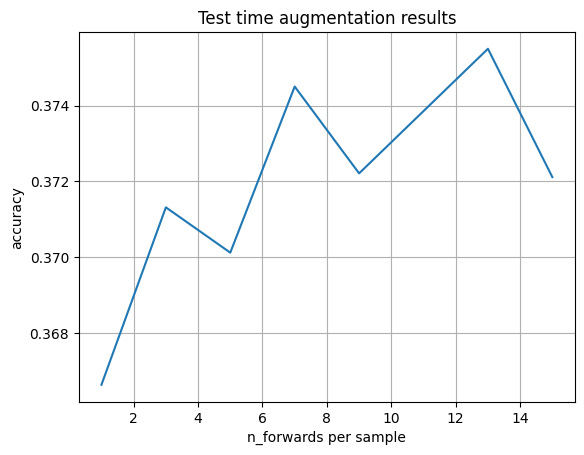

In [ ]:
plt.plot(n_forwards, tta_accuracy)
plt.grid()
plt.xlabel('n_forwards per sample')
plt.ylabel('accuracy')
plt.title('Test time augmentation results')

Normally you should get 1-2% improvement of accuracy here.